In [153]:
# Common packages
import numpy as np
import pandas as pd
import requests
import math
from astropy.constants import sigma_sb, L_sun
from bs4 import BeautifulSoup as BS
import itertools
import warnings
warnings.filterwarnings('ignore')

# Visuals
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib import cm

# Models
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import random

# Metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.metrics import recall_score, precision_score, classification_report
from sklearn import metrics


In [18]:
HZ_final = pd.read_csv('HZ_final.csv')

In [19]:
HZ_final = HZ_final.drop(columns = ['Unnamed: 0'])

In [20]:
HZ_final.columns

Index(['pl_name', 'pl_orbper_yrs', 'st_mass_x', 'sy_snum', 'sy_pnum',
       'pl_orbper', 'pl_orbsmax', 'pl_bmasse', 'pl_bmassj', 'st_teff',
       'st_rad', 'ra', 'dec', 'sy_dist', 'spec_type', 'st_rad_m', 'st_lum',
       'st_lum_sol', 'r_0', 'r_1', 'hab_zone'],
      dtype='object')

In [21]:
features = ['pl_orbper_yrs', 'st_mass_x', 'sy_snum', 'sy_pnum',
       'pl_orbper', 'pl_orbsmax', 'st_rad_m']

In [22]:
target = HZ_final.hab_zone

In [25]:
X_train, X_test, y_train, y_test = train_test_split(HZ_final[features], target, random_state=13 ,test_size=0.8)

Training:  0 vs. Testing:  0


# Creating Poly Features

In [31]:
def poly_df (df, degree):
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_data = poly.fit_transform(df)
    poly_columns = poly.get_feature_names(df.columns)
    HZ_poly = pd.DataFrame(poly_data, columns=poly_columns)
    return HZ_poly

In [34]:
HZ_poly  = poly_df(HZ_final[features], 2)

In [35]:
X_train_py, X_test_py, y_train_py, y_test_py = train_test_split(HZ_poly, target, random_state=13, test_size=0.8)

# Random Sampling

> Boostrap method

In [44]:
np.mean(X_train_py.pl_orbsmax)

0.8992515603712646

In [40]:
sample_mean = []

for i in range(100):
    y = random.sample(X_train_py.pl_orbsmax.to_list(), 10)
    avg = np.mean(y)
    sample_mean.append(avg)

In [42]:
np.mean(sample_mean)

0.7222178416589784

In [47]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [48]:
X_over, y_over = oversample.fit_resample(X_train_py, y_train_py)

In [52]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [53]:
X_under, y_under = undersample.fit_resample(X_train_py, y_train_py)

In [57]:
weighted = HZ_final.hab_zone.value_counts(normalize=True)

In [59]:
weighted = dict(zip(weighted.index, weighted.values))

In [60]:
weighted

{0: 0.9763257575757576, 1: 0.023674242424242424}

In [101]:
weights_r = {1: 0.9763257575757576, 0: 0.023674242424242424}

In [217]:
scal_pos = int(weights_r[1]/weights_r[0])

# Modeling

> Logistic Regression

In [121]:
def log_reg_model(X_train, y_train, X_test, y_test, weights = 'balanced'):
    logreg = LogisticRegression(class_weight = weights)
    logreg = logreg.fit(X_train, y_train)
    logreg_pred = logreg.predict(X_test)
    score = f1_score(y_test, logreg_pred, average ='binary')
    print("The F1 score for this model is {}".format(score))
    
    print("\nClassification report :\n",(classification_report(y_test, logreg_pred)))
    return(logreg_pred)

In [169]:
# confusion matrix plotter
def plot_confusion_matrix(
    target,
    pred, 
    classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
):
    '''
    Function that prints and plots a model's confusion matrix.
    Input
    -----
    cm : sklearn confusion matrix
        `sklearn.metrics.confusion_matrix(y_true, y_pred)`
    classes : list (str)
        Names of target classes.
    Optional input
    --------------
    normalize : bool
        Whether to apply normalization (default=False).
        Normalization can be applied by setting `normalize=True`.
    title : str
        Title of the returned plot.
    cmap : matplotlib color map
        For options, visit:
        `https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html`
    Output
    ------
    Prints a stylized confusion matrix.
    '''
    # convert to percentage, if normalize set to True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = confusion_matrix(target, pred)
    # plot
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # format true positives and others
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=16,
                 horizontalalignment="center", verticalalignment="center",
                 color="orange" if cm[i, j] > thresh else "black")
    # add axes labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

The F1 score for this model is 0.0

Classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3305
           1       0.00      0.00      0.00        75

    accuracy                           0.98      3380
   macro avg       0.49      0.50      0.49      3380
weighted avg       0.96      0.98      0.97      3380



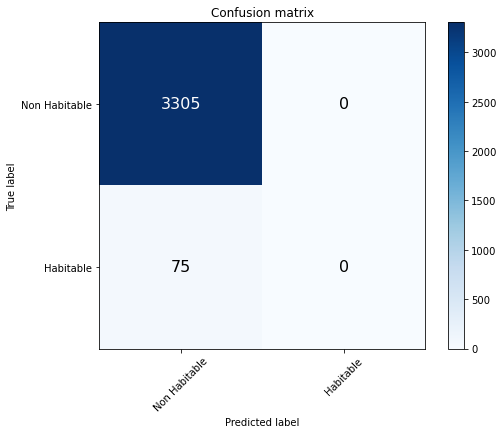

In [123]:
plot_confusion_matrix(
    y_test,
    pred = log_reg_model(X_train, y_train, X_test, y_test),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

The F1 score for this model is 0.0

Classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3305
           1       0.00      0.00      0.00        75

    accuracy                           0.98      3380
   macro avg       0.49      0.50      0.49      3380
weighted avg       0.96      0.98      0.97      3380



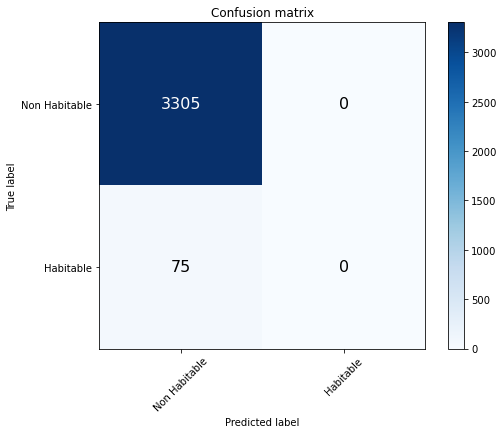

In [125]:
plot_confusion_matrix(
    y_test,
    pred = log_reg_model(X_train, y_train, X_test, y_test, weights=weights_r),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

The F1 score for this model is 0.0

Classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3305
           1       0.00      0.00      0.00        75

    accuracy                           0.98      3380
   macro avg       0.49      0.50      0.49      3380
weighted avg       0.96      0.98      0.97      3380



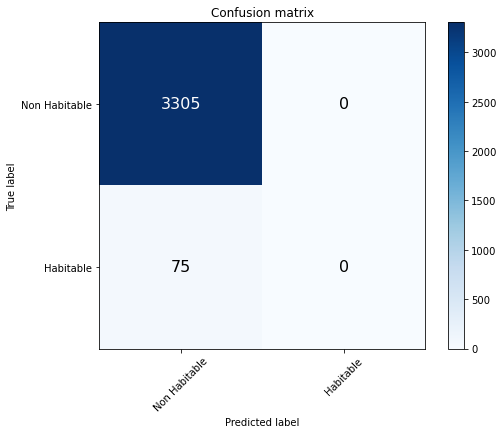

In [126]:
plot_confusion_matrix(
    y_test,
    pred = log_reg_model(X_train_py, y_train, X_test_py, y_test, weights=weights_r),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

The F1 score for this model is 0.0

Classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3305
           1       0.00      0.00      0.00        75

    accuracy                           0.98      3380
   macro avg       0.49      0.50      0.49      3380
weighted avg       0.96      0.98      0.97      3380



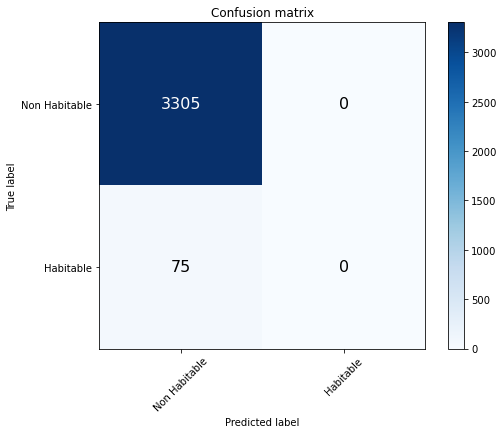

In [127]:
plot_confusion_matrix(
    y_test,
    pred = log_reg_model(X_under, y_under, X_test_py, y_test, weights=weights_r),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

> Radnom Forest

In [132]:
def randomforest(X_train, y_train, X_test, y_test, est, depth, weights = 'balanced'):
    randfor = RandomForestClassifier(n_estimators = est, max_depth = depth, class_weight = weights, random_state = 13)
    randfor = randfor.fit(X_train, y_train)
    random_pred = randfor.predict(X_test)
    score = f1_score(y_test, random_pred)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, random_pred)))
    
    return(random_pred)

The F1 score for this model is 0.3711340206185567

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      3305
           1       0.25      0.72      0.37        75

    accuracy                           0.95      3380
   macro avg       0.62      0.84      0.67      3380
weighted avg       0.98      0.95      0.96      3380



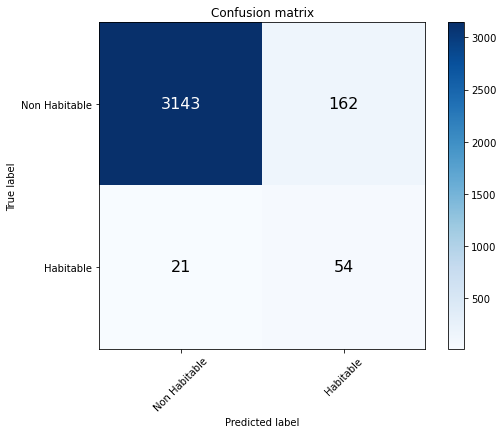

In [133]:
plot_confusion_matrix(
    y_test,
    pred = randomforest(X_train, y_train, X_test, y_test, 20, 5),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

The F1 score for this model is 0.3917525773195877

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      3305
           1       0.26      0.76      0.39        75

    accuracy                           0.95      3380
   macro avg       0.63      0.86      0.68      3380
weighted avg       0.98      0.95      0.96      3380



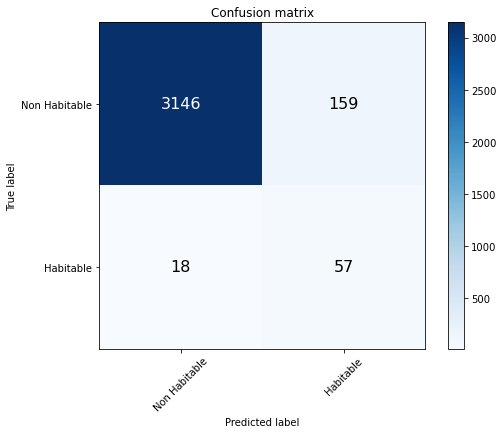

In [141]:
plot_confusion_matrix(
    y_test,
    pred = randomforest(X_train, y_train, X_test, y_test, 20, 5, weights_r),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

The F1 score for this model is 0.30388692579505294

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      3305
           1       0.21      0.57      0.30        75

    accuracy                           0.94      3380
   macro avg       0.60      0.76      0.64      3380
weighted avg       0.97      0.94      0.95      3380



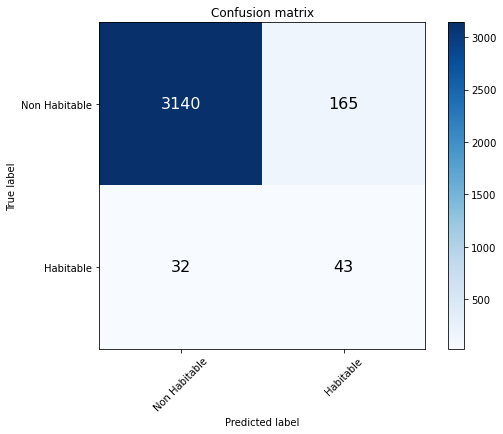

In [148]:
plot_confusion_matrix(
    y_test,
    pred = randomforest(X_train_py, y_train_py, X_test_py, y_test, 20, 5, weights_r),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

> XGboost

In [146]:
def xgboost(X_train, y_train, X_test, y_test, est, depth ):
    xgb = XGBClassifier(n_estimators = est, max_depth = depth)
    xgb.fit(X_train, y_train)
    xgb_preds = xgb.predict(X_test)
    score = f1_score(y_test, xgb_preds)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, xgb_preds)))
    return(xgb_preds)
    

[14:22:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The F1 score for this model is 0.26

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3305
           1       0.52      0.17      0.26        75

    accuracy                           0.98      3380
   macro avg       0.75      0.58      0.62      3380
weighted avg       0.97      0.98      0.97      3380



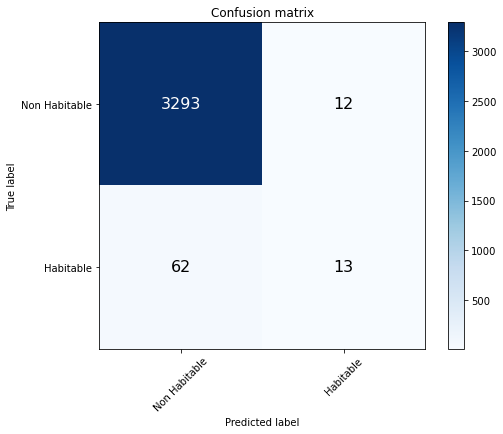

In [147]:
plot_confusion_matrix(
    y_test,
    pred = xgboost(X_train, y_train, X_test, y_test, 20, 5),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

[14:24:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The F1 score for this model is 0.13084112149532712

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3305
           1       0.22      0.09      0.13        75

    accuracy                           0.97      3380
   macro avg       0.60      0.54      0.56      3380
weighted avg       0.96      0.97      0.97      3380



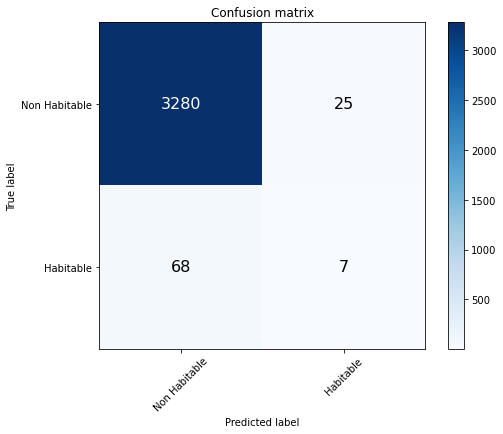

In [151]:
plot_confusion_matrix(
    y_test,
    pred = xgboost(X_train_py, y_train, X_test_py, y_test, 20, 5),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

> Light Gradient Boost

In [202]:
def lightgb(X_train, y_train, X_test, y_test, weight = None):
    lgbm = lgb.LGBMClassifier(boosting_type='gbdt', 
                             num_leaves = 31, 
                             max_depth = 7, 
                             learning_rate = 0.5, 
                             class_weight = weight, 
                             random_state = 13,
                             n_jobs = -1)
    lgbm = lgbm.fit(X_train, y_train)
    lgb_pred = lgbm.predict(X_test)
    score = f1_score(y_test, lgb_pred)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, lgb_pred)))
    return(lgb_pred)

The F1 score for this model is 0.26548672566371684

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3305
           1       0.39      0.20      0.27        75

    accuracy                           0.98      3380
   macro avg       0.69      0.60      0.63      3380
weighted avg       0.97      0.98      0.97      3380



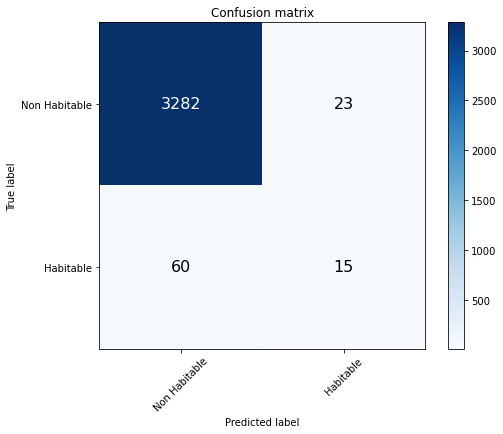

In [203]:
plot_confusion_matrix(
    y_test,
    pred = lightgb(X_train, y_train, X_test, y_test),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

# Search best parameters:

> Grid Search with random forest

In [229]:
weights_r

{1: 0.9763257575757576, 0: 0.023674242424242424}

In [234]:
rf_grid_search = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': [1, 2, 3, 4, 5 , 6, 7],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
    'min_samples_split': [2, 4, 6, 8, 10],
    'n_estimators': [100, 150, 200, 250],
    'class_weight': [{1: 10, 0: 1}, {1: 20, 0: 1}, {1: 30, 0: 1}, {1: 40, 0: 1}]
}

In [235]:
rf = RandomForestClassifier()


grid_search = GridSearchCV(estimator = rf, param_grid = rf_grid_search, cv = 3, n_jobs = -1, verbose = 2)

In [236]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 129360 candidates, totalling 388080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20},
                                          {0: 1, 1: 30}, {0: 1, 1: 40}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             verbose=2)

In [237]:
grid_search.best_params_

{'class_weight': {1: 10, 0: 1},
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [180]:
def randomforestbest(X_train, y_train, X_test, y_test, citerion, est, depth, maxf, minleaf, minsplit,  weights = 'balanced'):
    randfor = RandomForestClassifier(criterion = citerion ,
                                     n_estimators = est, 
                                     max_depth = depth, 
                                     max_features = maxf,
                                     min_samples_leaf = minleaf,
                                     min_samples_split = minsplit, 
                                     class_weight = weights, 
                                     random_state = 13)
    randfor = randfor.fit(X_train, y_train)
    random_pred = randfor.predict(X_test)
    score = f1_score(y_test, random_pred)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, random_pred)))
    
    return(random_pred)

The F1 score for this model is 0.0

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3305
           1       0.00      0.00      0.00        75

    accuracy                           0.98      3380
   macro avg       0.49      0.50      0.49      3380
weighted avg       0.96      0.98      0.97      3380



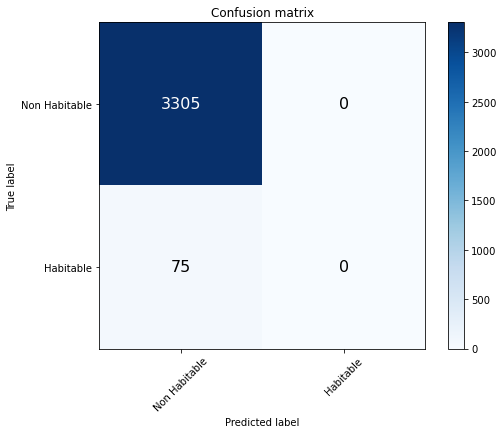

In [239]:
plot_confusion_matrix(
    y_test,
    pred = randomforestbest(X_train, y_train, X_test, y_test, 'gini', 50, 1, 1, 1, 2, {1: 10, 0: 1}),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

> Xgboost

In [265]:
xgb_params = { 'nthread': [3, 4, 5],
              'objective': ['binary:logistic'],
              'learning_rate': [5, 10],
              'max_depth': [9, 10, 11],
              'reg_alpha': [1.09, 1.1, 1.11],
              'reg_lambda': [1.19, 1.2, 1.25],
              'subsample': [0.81, 0.83, 0.89],
              'n_estimators': [180, 200, 220],
              'scale_pos_weight': [5, 8, 10]
}

In [266]:
xgb = XGBClassifier()

In [267]:
xgb_grd_search = GridSearchCV(estimator = xgb, param_grid = xgb_params, cv = 3, n_jobs = -1, verbose =2)

In [ ]:
xgb_grd_search.fit(X_train, y_train)

Fitting 3 folds for each of 4374 candidates, totalling 13122 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

In [223]:
xgb_grd_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 10,
 'n_estimators': 200,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 1.1,
 'reg_lambda': 1.2,
 'scale_pos_weight': 10,
 'subsample': 0.8}

In [225]:
def xgboostbest(X_train, y_train, X_test, y_test, lr, est, depth, nth, obj, alpha, lmda, sub, spw):
    xgb = XGBClassifier(learning_rate = lr,
                        n_estimators = est,
                        max_depth = depth, 
                        nthread = nth, 
                        objective = obj, 
                        reg_alpha = alpha, 
                        reg_lambda = lmda, 
                        subsample = sub, 
                       scale_pos_weight = spw)
    xgb.fit(X_train, y_train)
    xgb_preds = xgb.predict(X_test)
    score = f1_score(y_test, xgb_preds)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, xgb_preds)))
    return(xgb_preds)

[15:00:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The F1 score for this model is 0.4551724137931034

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3305
           1       0.47      0.44      0.46        75

    accuracy                           0.98      3380
   macro avg       0.73      0.71      0.72      3380
weighted avg       0.98      0.98      0.98      3380



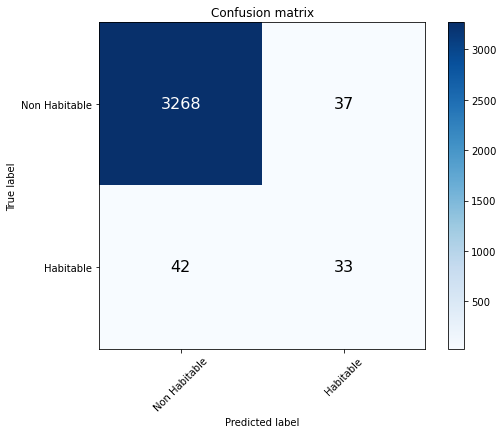

In [228]:
plot_confusion_matrix(
    y_test,
    pred = xgboostbest(X_train, y_train, X_test, y_test, 0.05, 200, 10, 4,'binary:logistic', 1.1, 1.2, 0.8, 10),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

> Light GBM

In [260]:
lgbm_params = {'n_estimators': [100, 150, 200, 250],
    'colsample_bytree': [0.65, 0.7],
    'max_depth': [5, 15, 20],
    'num_leaves': [30, 40, 50],
    'reg_alpha': [1.0, 1.1],
    'reg_lambda': [1.45, 1.5],
    'min_split_gain': [0.42, 0.4, 0.43],
    'subsample': [0.7, 0.75],
    'subsample_freq': [20],
    'class_weight': [{1: 30, 0: 1}, {1: 35, 0: 1}] 
}

In [261]:
lgbm = lgb.LGBMClassifier()

In [262]:
lgbm_grd_search = GridSearchCV(estimator = lgbm, param_grid = lgbm_params, cv = 3, n_jobs = -1, verbose =2)

In [263]:
lgbm_grd_search.fit(X_train, y_train)

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1244 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2376 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 3836 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 5616 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 7724 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 10152 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 10345 out of 10368 | elapsed:  1.1min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 10368 out of 10368 | elapsed:  1.1min finished


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 30}, {0: 1, 1: 35}],
                         'colsample_bytree': [0.7, 0.75],
                         'max_depth': [5, 15, 20],
                         'min_split_gain': [0.42, 0.4, 0.43],
                         'n_estimators': [100, 150, 200, 250],
                         'num_leaves': [30, 40, 50], 'reg_alpha': [1.0, 1.1],
                         'reg_lambda': [1.45, 1.5], 'subsample': [0.7, 0.75],
                         'subsample_freq': [20]},
             verbose=2)

In [264]:
lgbm_grd_search.best_params_

{'class_weight': {1: 30, 0: 1},
 'colsample_bytree': 0.7,
 'max_depth': 15,
 'min_split_gain': 0.4,
 'n_estimators': 250,
 'num_leaves': 30,
 'reg_alpha': 1.1,
 'reg_lambda': 1.5,
 'subsample': 0.7,
 'subsample_freq': 20}

In [257]:
def lightgbest(X_train, y_train, X_test, y_test, weight = None):
    lgbm = lgb.LGBMClassifier(colsample_bytree = 0.7,
                             boosting_type='gbdt', 
                             num_leaves = 30, 
                              min_split_gain = 0.4,
                              max_depth = 15, 
                             reg_alpha = 1.1,
                             reg_lambda = 1.5,
                             class_weight = weight, 
                             random_state = 13,
                             subsample = 0.7,
                             subsample_freq= 20)
    lgbm = lgbm.fit(X_train, y_train)
    lgb_pred = lgbm.predict(X_test)
    score = f1_score(y_test, lgb_pred)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, lgb_pred)))
    return(lgb_pred)

The F1 score for this model is 0.46086956521739125

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3305
           1       0.34      0.71      0.46        75

    accuracy                           0.96      3380
   macro avg       0.67      0.84      0.72      3380
weighted avg       0.98      0.96      0.97      3380



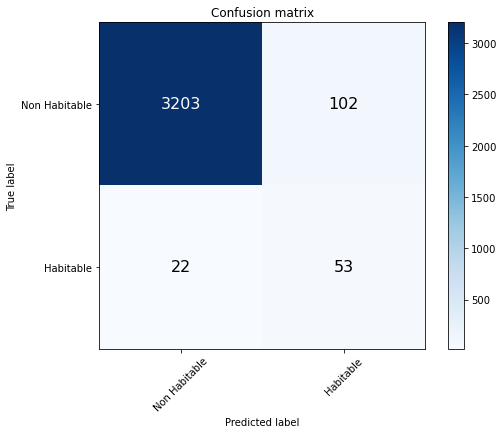

In [258]:
plot_confusion_matrix(
    y_test,
    pred = lightgbest(X_train, y_train, X_test, y_test, {1: 30, 0: 1}),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)